In [14]:
images_dir = '/content/gdrive/MyDrive/Statistical computing Final project/images'

In [ ]:
# !pip uninstall sklearn -y
# !pip install https://github.com/Santosh-Gupta/scikit-learn/archive/master.zip
# !pip install scipy
# !pip install umap-learn
!pip install tomotopy
!pip install lda_classification
!pip install Cython
import logging
import importlib
import sklearn.manifold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import cm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel
from lda_classification.model import TomotopyLDAVectorizer
!python -m spacy download en_core_web_sm
importlib.reload(sklearn.manifold)



In [12]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入google帳號

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/files/model_train_with_label.csv",encoding='latin1')
test = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/files/model_test_with_label.csv",encoding='latin1')
# df=pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/files/lemma_text.csv",encoding='latin1')
train.head()

,lemma_text,sentiment,label
0,menyrbie phil_gahan chrisitv,Neutral,1
1,advice talk neighbour family exchange phone nu...,Positive,2
2,coronavirus australia woolworth give elderly d...,Positive,2
3,food stock one empty please dont panic enough ...,Positive,2
4,ready go supermarket covid outbreak im paranoi...,Extremely Negative,0


In [ ]:
# ogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project

use_umap = False #make this True if you want to use UMAP for your visualizations

min_df = 5 #Minimum number for document frequency in the corpus
rm_top = 5 #Remove top n frequent words

In [ ]:
train['lemma_text']=train['lemma_text'].astype(str)
test['lemma_text']=test['lemma_text'].astype(str)

In [ ]:
# hdp_model = HDPModel(min_df=min_df, rm_top=rm_top)
# hdp_model.optim_interval = 5
# for d in train['lemma_text']:
#     hdp_model.add_doc(d)
# hdp_model.burn_in = 100
# hdp_model.train(0, workers=workers)
# for i in range(0, 1000, 10):
#     hdp_model.train(10, workers=workers)
#     print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp_model.ll_per_word, hdp_model.live_k))

# num_of_topics = hdp_model.live_k

In [ ]:
vectorizer = TomotopyLDAVectorizer(num_of_topics=32,workers=workers, min_df=min_df, rm_top=rm_top)
x_train = vectorizer.fit_transform(train['lemma_text'])
x_test = vectorizer.transform(test['lemma_text'])

In [ ]:
# # save numpy array as csv file
# from numpy import asarray
# from numpy import savetxt

# # save to csv file
# savetxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_train_32.csv', x_train, delimiter=',')
# savetxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_test_32.csv', x_test, delimiter=',')

In [15]:
# savetxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_train.csv', x_train, delimiter=',')
# savetxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_test.csv', x_test, delimiter=',')
from numpy import genfromtxt
x_train = genfromtxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_train_32.csv', delimiter=',')
x_test = genfromtxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_test_32.csv', delimiter=',')


In [16]:
title = "PCA Visualization of the Dataset using {}"
if use_umap is True:
    from umap import UMAP
    dim_reducer = UMAP(n_components=2)
    title = title.format("UMAP")
else:
    from sklearn.manifold import TSNE
    dim_reducer = TSNE(n_components=2)
    title = title.format("TSNE")
x_transform = np.concatenate((x_train, x_test))
x_transform = StandardScaler().fit_transform(x_transform)
x_transform = dim_reducer.fit_transform(x_transform)
# savetxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_transform32.csv', x_transform, delimiter=',')

In [19]:
x_transform=genfromtxt('/content/gdrive/MyDrive/Statistical computing Final project/files/x_transform32.csv', delimiter=',')

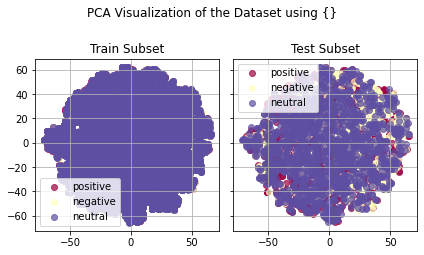

In [20]:
def plot_topic_clusters(ax, x2d, y, labels):
    ax.set_aspect("equal")
    colors = cm.get_cmap("Spectral", len(labels))
    for i, l in enumerate(labels):
        c = colors(i / len(labels))
        ax.scatter(x2d[y == i, 0], x2d[y == i, 1], color=c, label=l, alpha=0.7)
    ax.grid()
    ax.legend()
    ax.set(adjustable='box', aspect='equal')
    return ax
labels=['positive', 'negative', 'neutral']
title = "PCA Visualization of the Dataset using {}"
x2d_train = x_transform[:x_train.shape[0], :]
x2d_test = x_transform[x_train.shape[0]:, :]
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
plot_topic_clusters(axes[0], x2d_train, train.label, labels)
plot_topic_clusters(axes[1], x2d_test, test.label, labels)
axes[0].set_title("Train Subset")
axes[1].set_title("Test Subset")
fig.suptitle(title)
plt.tight_layout()
plt.savefig(f"{images_dir}/PCA Visualization of the Dataset.png")
plt.show()

## SVM

In [21]:
from sklearn.decomposition import PCA
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
vectorizer = TomotopyLDAVectorizer(num_of_topics=32, workers=workers, min_df=min_df,
                                   rm_top=rm_top)
clf = SVC()
pca = PCA(n_components=0.95)
pipe = Pipeline([("vectorizer", vectorizer), ("scalar", StandardScaler()),
                 ("classifier", clf)])
 
 
 
 
results = cross_val_score(pipe, test['lemma_text'], test.label, cv=folds, n_jobs=2, verbose=1,
                          scoring="accuracy")
                          
                          
print("Accuracy -> mean: {}\t std: {}".format(results.mean(), results.std()))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 17.2min


Accuracy -> mean: 0.4175101374809054	 std: 0.02148635843751845


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 37.6min finished
